### Adv. Hydrology Project: Analysis of different forcing data on SUMMA simulations of snow
---

#### What are the impacts of using remotely sensed incoming radiation data (CERES) versus in situ measurements (CUES) on modeling temporal snow patterns?

SUMMA model sensitivity analysis comparing model runs using radiation forcing data from:
* [CUES snow study site data](https://snow.ucsb.edu/)
* [CERES remote sensing derived products](https://eosweb.larc.nasa.gov/project/ceres/syn1deg-day_ed4a)

Snow pattern evaluation variables:
* April 1st SWE
* Peak SWE accumulation
* Snow disappearance date
* Snow surface temperature
***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import numpy as np
import pandas as pd

In [11]:
# load outputs from both model runs
cues = xr.open_dataset('/home/jovyan/cues/summa_setup/output/template_output_output_cues_timestep.nc')
ceres = xr.open_dataset('/home/jovyan/cues/summa_setup/output/template_output_output_cues-ceres_timestep.nc')

***
### SWE Timelines:

In [12]:
def get_snow_disappearance_date(x,t):
    '''get date of last snow disappearance'''
    # reverse the datset
    x_r = x
    t_r = t
    # find the first non-zero SWE value
    for i in range(0,len(x_r)):
        if x_r[i] > 1:
            idx = i-1
    # dis date is the date of the last zero SWE value
    dis_date = t_r[idx]
    return dis_date # return the date

/srv/conda/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


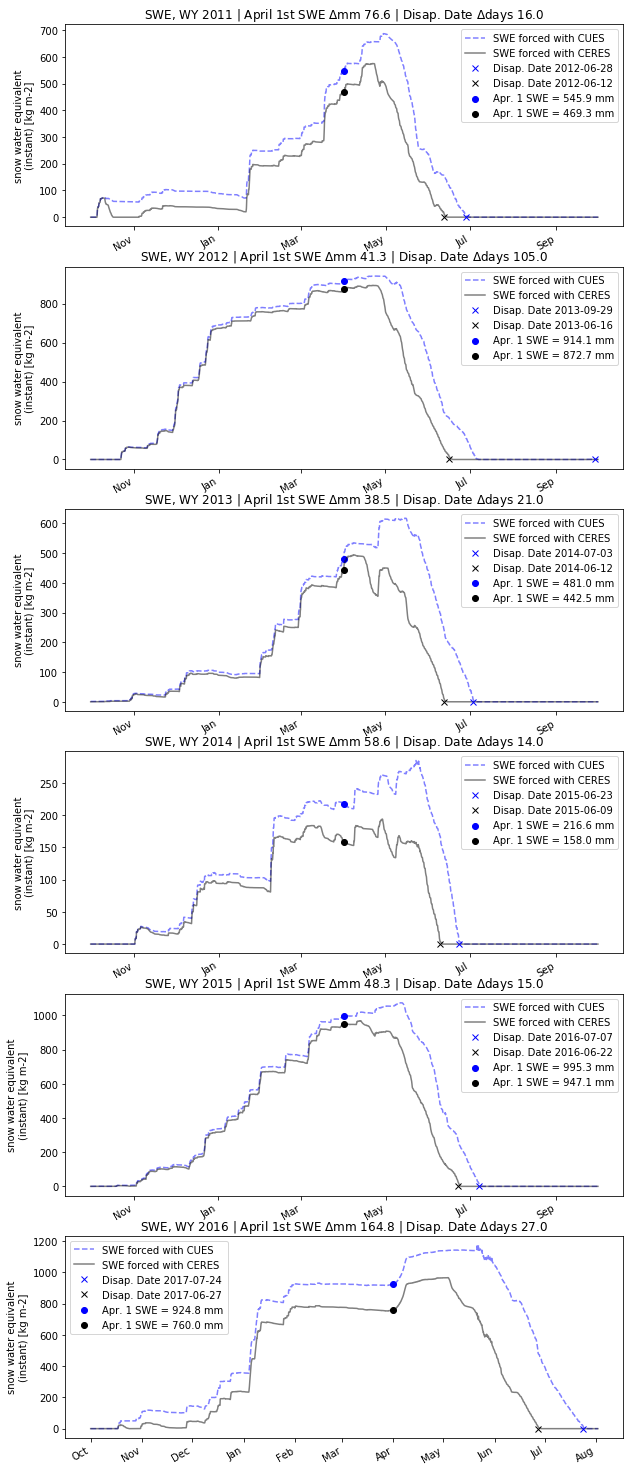

In [13]:
# Plot SWE timelines

# Define our water years
water_years = np.array(np.linspace(2011,2016,6),dtype='int32')

# resample to daily mean SWE values for snow disappearance date
cues_daily_mean = cues.scalarSWE.resample(time='1D').mean()
ceres_daily_mean = ceres.scalarSWE.resample(time='1D').mean()

# initialize plots
fig, ax = plt.subplots(len(water_years),1,figsize=(10,26))

i=0 # for interating over subplots

for year in water_years: # plot each water year individually
    
    # Find snow disappearance date
    cues_dis_date = get_snow_disappearance_date(cues_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)],
                                               cues_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].time.values)
    ceres_dis_date = get_snow_disappearance_date(ceres_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)],
                                                ceres_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].time.values)

    
    # Plot April 1st SWE from both model runs
    april1 = datetime.strptime('{}-04-01 00:00:00'.format(year+1),'%Y-%m-%d %H:%M:%S')
    ax[i].scatter(april1, cues.scalarSWE.loc[april1].values[0],
           color='b',label='Apr. 1 SWE = {} mm'.format((np.round(cues.scalarSWE.loc[april1].values[0],1))))
    ax[i].scatter(april1, ceres.scalarSWE.loc[april1].values[0],
           color='k',label='Apr. 1 SWE = {} mm'.format(np.round(ceres.scalarSWE.loc[april1].values[0],1)))
    
    # Plot SWE from both model runs
    cues.scalarSWE.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].plot(ax=ax[i],color='b',linestyle='--',alpha=0.5,
                                                                              label='SWE forced with CUES')
    ceres.scalarSWE.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].plot(ax=ax[i],color='k',linestyle='-',alpha=0.5,
                                                                               label='SWE forced with CERES')
    
    # Plot snow disappearance dates
    ax[i].plot([cues_dis_date],[0],'xb',label='Disap. Date {}'.format(np.datetime_as_string(cues_dis_date)[0:10]))
    ax[i].plot([ceres_dis_date],[0],'xk',label='Disap. Date {}'.format(np.datetime_as_string(ceres_dis_date)[0:10]))
    
    # Format the plot for this water ayear
    ax[i].set_title('SWE, WY {} | April 1st SWE $\Delta$mm {} | Disap. Date $\Delta$days {}'.format(year,
                                                                       np.round(cues.scalarSWE.loc[april1].values[0]-ceres.scalarSWE.loc[april1].values[0],1),
                                                                      (cues_dis_date-ceres_dis_date).astype('timedelta64[D]') / np.timedelta64(1, 'D')))
   
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i].set_xlabel('')
    
    # iterate for subplots
    i+=1
    
fig.savefig('swe_plots.png',dpi=300)

***
### SWE Accumulation Curves, Peak SWE Date

In [14]:
def get_accumulation(x,t):
    '''get array of values from x that are accumulating'''
    c = 0 # accumulation indexer
    accum = [x[0]] # initialize with our first value
    accum_t = [t[0]]
    for n in range(1,len(x)):
        if x[n] >= accum[c]: # if SWE is greater or equal than previous day
            accum.append(x[n]) # add to accumulation
            accum_t.append(t[n])
            c+=1 # accumulation indexer
    return np.array([accum, accum_t]) # return np array of accumulation and time

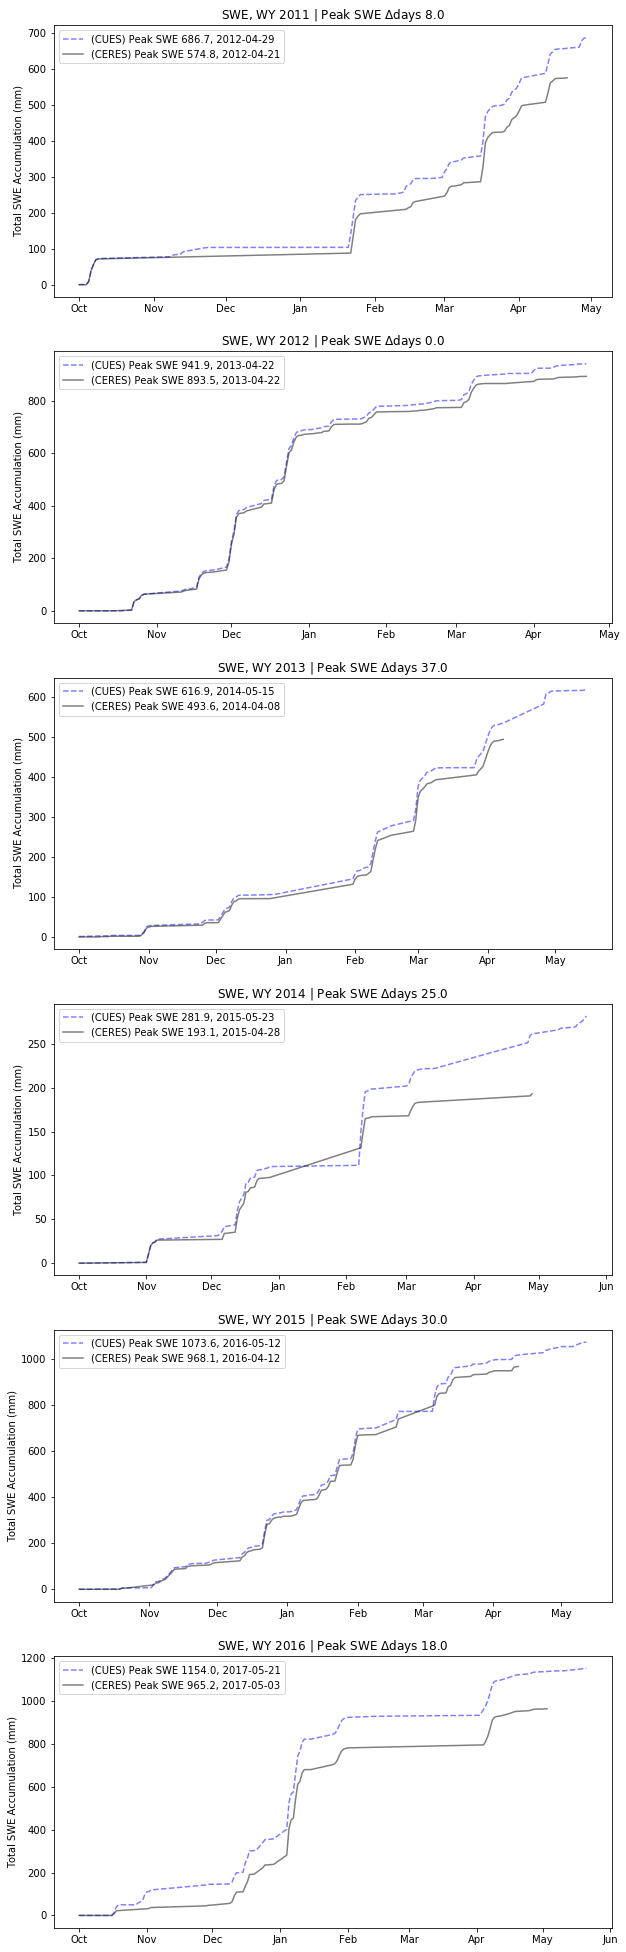

In [15]:
# compare SWE accumulation curves
water_years = np.array(np.linspace(2011,2016,6),dtype='int32') # define our water years

# resample to daily mean SWE values
cues_daily_mean = cues.scalarSWE.resample(time='1D').mean()
ceres_daily_mean = ceres.scalarSWE.resample(time='1D').mean()

fig, ax = plt.subplots(len(water_years),1,figsize=(10,35))
i=0
for year in water_years:
    # compute and plot SWE accumulation curves for each water year
    cues_swe_accum = get_accumulation(cues_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].values,
                                      cues_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].time.values)
    ceres_swe_accum = get_accumulation(ceres_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].values,
                                       ceres_daily_mean.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].time.values)
   
    # Plot SWE accumulation curves
    ax[i].plot(cues_swe_accum[1],cues_swe_accum[0],
               color='b',linestyle='--',alpha=0.5,
               label='(CUES) Peak SWE {}, {}'.format(np.round(cues_swe_accum[0].max(),1),
                                                     np.datetime_as_string(cues_swe_accum[1].max())[0:10]))
    ax[i].plot(ceres_swe_accum[1],ceres_swe_accum[0],
               color='k',linestyle='-',alpha=0.5,
               label='(CERES) Peak SWE {}, {}'.format(np.round(ceres_swe_accum[0].max(),1),
                                                      np.datetime_as_string(ceres_swe_accum[1].max())[0:10]))
    
    # Format plot title
    ax[i].set_title('SWE, WY {} | Peak SWE $\Delta$days {}'.format(year,
                                                              (cues_swe_accum[1].max()-ceres_swe_accum[1].max()).astype('timedelta64[D]') / np.timedelta64(1, 'D')))
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Total SWE Accumulation (mm)')

    
    i+=1

fig.savefig('swe_accum_plots.png',dpi=300)

***
### Snow surface temperature

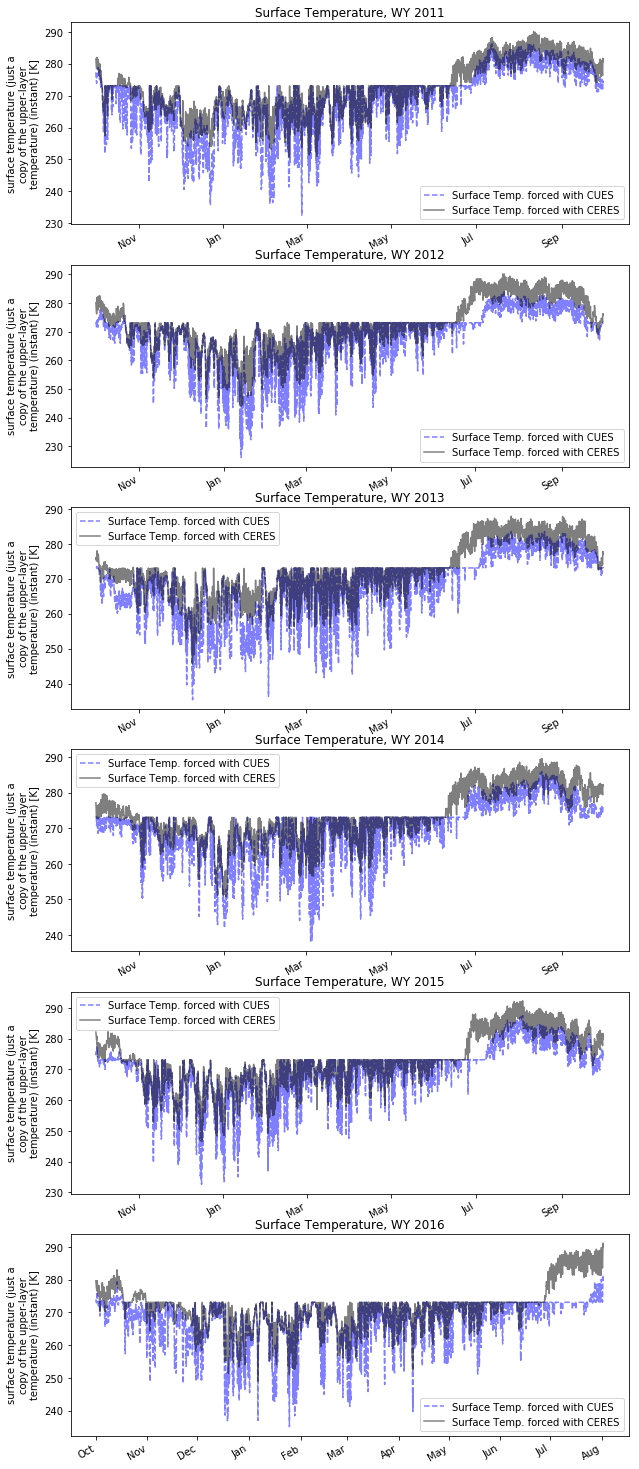

In [16]:
# Plot Tss timelines
# compare snow surface temperature

# Define our water years
water_years = np.array(np.linspace(2011,2016,6),dtype='int32')

# initialize plots
fig, ax = plt.subplots(len(water_years),1,figsize=(10,26))

i=0 # for interating over subplots

for year in water_years: # plot each water year individually
    
      
    # Plot surface temperature from both model runs
    cues.scalarSurfaceTemp.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].plot(ax=ax[i],color='b',linestyle='--',alpha=0.5,label='Surface Temp. forced with CUES')
    ceres.scalarSurfaceTemp.loc['{}-10-01'.format(year):'{}-9-30'.format(year+1)].plot(ax=ax[i],color='k',linestyle='-',alpha=0.5,label='Surface Temp. forced with CERES')
    
    # Format the plot for this water ayear
    ax[i].set_title('Surface Temperature, WY {}'.format(year))
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i].set_xlabel('')
    
    # iterate for subplots
    i+=1
    
fig.savefig('surface_temp_plots.png',dpi=300)

### Look at a few days in the accumulation season:

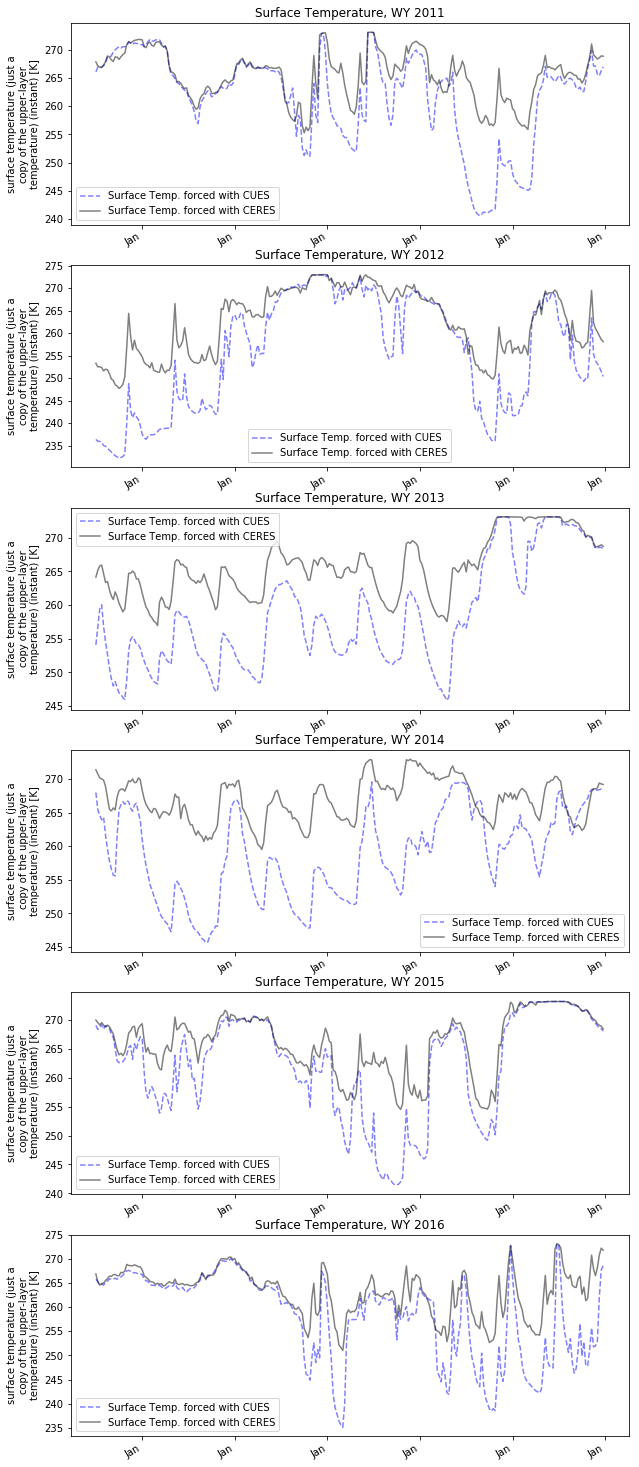

In [20]:
# initialize plots
fig, ax = plt.subplots(len(water_years),1,figsize=(10,26))

i=0 # for interating over subplots

for year in water_years: # plot each water year individually
    
      
    # Plot surface temperature from both model runs
    cues.scalarSurfaceTemp.loc['{}-01-20'.format(year+1):'{}-01-30'.format(year+1)].plot(ax=ax[i],color='b',linestyle='--',alpha=0.5,label='Surface Temp. forced with CUES')
    ceres.scalarSurfaceTemp.loc['{}-01-20'.format(year+1):'{}-01-30'.format(year+1)].plot(ax=ax[i],color='k',linestyle='-',alpha=0.5,label='Surface Temp. forced with CERES')
    
    # Format the plot for this water ayear
    ax[i].set_title('Surface Temperature, WY {}'.format(year))
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i].set_xlabel('')
    
    # iterate for subplots
    i+=1
    
fig.savefig('accum_surface_temp_plots.png',dpi=300)

### Look at a few days in the melt season:

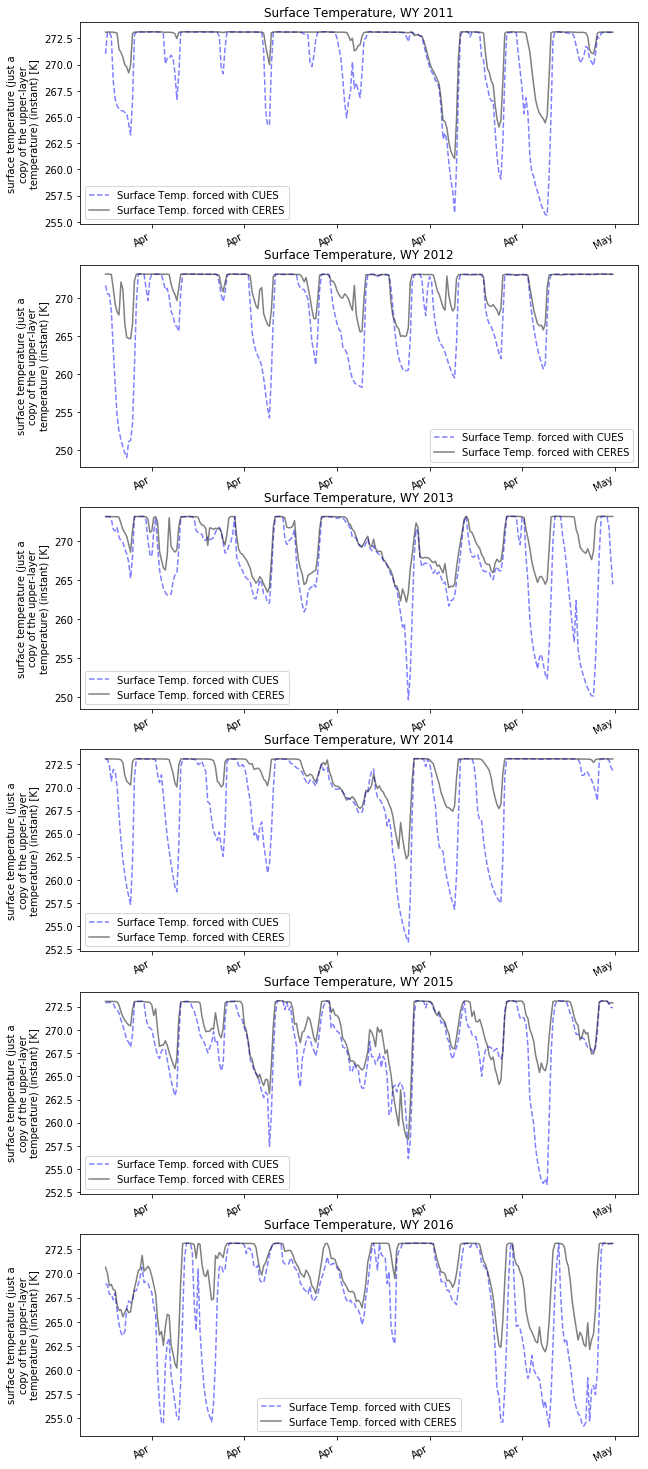

In [19]:
# initialize plots
fig, ax = plt.subplots(len(water_years),1,figsize=(10,26))

i=0 # for interating over subplots

for year in water_years: # plot each water year individually
    
      
    # Plot surface temperature from both model runs
    cues.scalarSurfaceTemp.loc['{}-04-20'.format(year+1):'{}-04-30'.format(year+1)].plot(ax=ax[i],color='b',linestyle='--',alpha=0.5,label='Surface Temp. forced with CUES')
    ceres.scalarSurfaceTemp.loc['{}-04-20'.format(year+1):'{}-04-30'.format(year+1)].plot(ax=ax[i],color='k',linestyle='-',alpha=0.5,label='Surface Temp. forced with CERES')
    
    # Format the plot for this water ayear
    ax[i].set_title('Surface Temperature, WY {}'.format(year))
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i].set_xlabel('')
    
    # iterate for subplots
    i+=1
    
fig.savefig('melt_surface_temp_plots.png',dpi=300)